### Анализ заработной платы

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


E:\work\tools\python\anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
work = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
work.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


* Визуальный анализ ряда

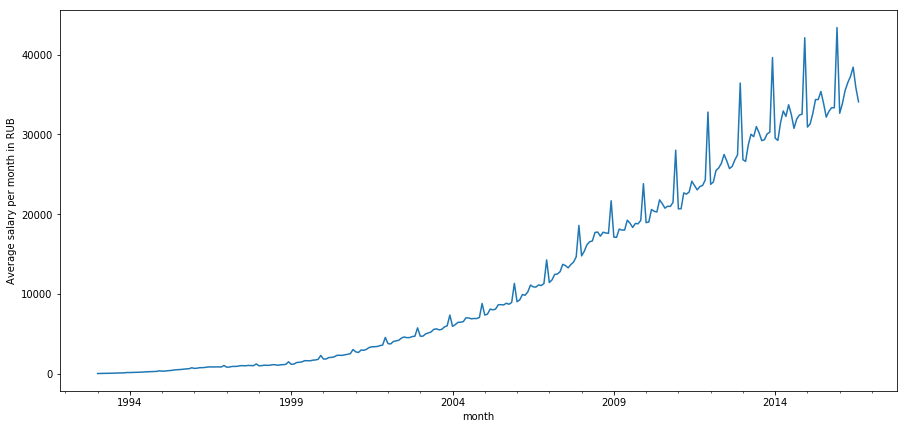

In [5]:
# Анализируем график
plt.figure(figsize(15,7))
work.WAG_C_M.plot()
plt.ylabel('Average salary per month in RUB')
pylab.show()

Критерий Дики-Фуллера:  0.9918495954854734


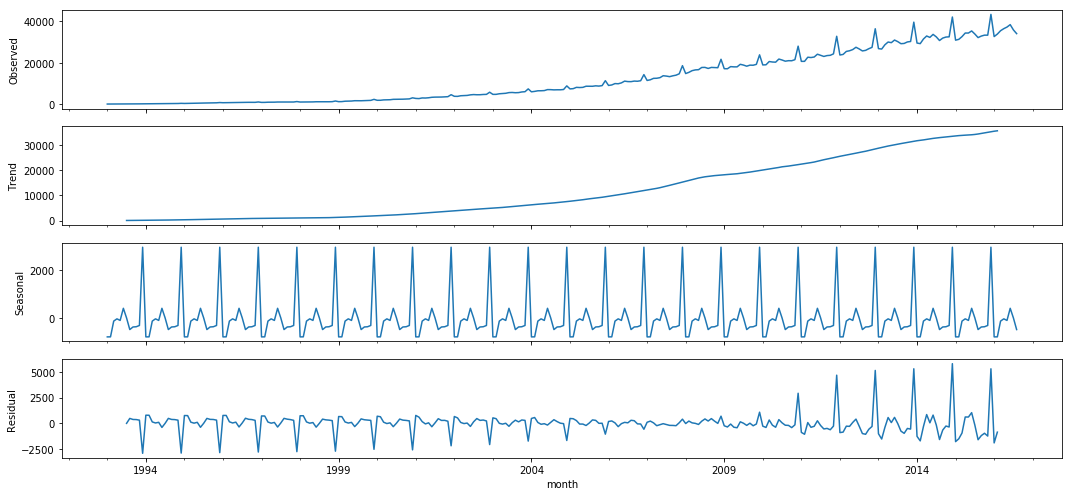

In [6]:
sm.tsa.seasonal_decompose(work.WAG_C_M).plot()
print("Критерий Дики-Фуллера: ", sm.tsa.stattools.adfuller(work.WAG_C_M)[1])
plt.show()

* Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


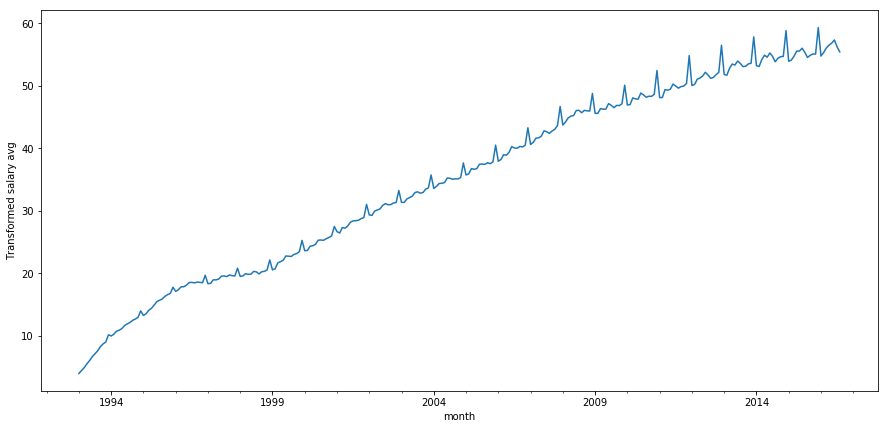

In [7]:
work['anti_disp'], lmbda = stats.boxcox(work.WAG_C_M)
plt.figure(figsize(15,7))
work.anti_disp.plot()
plt.ylabel(u'Transformed salary avg')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work.anti_disp)[1])

* Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


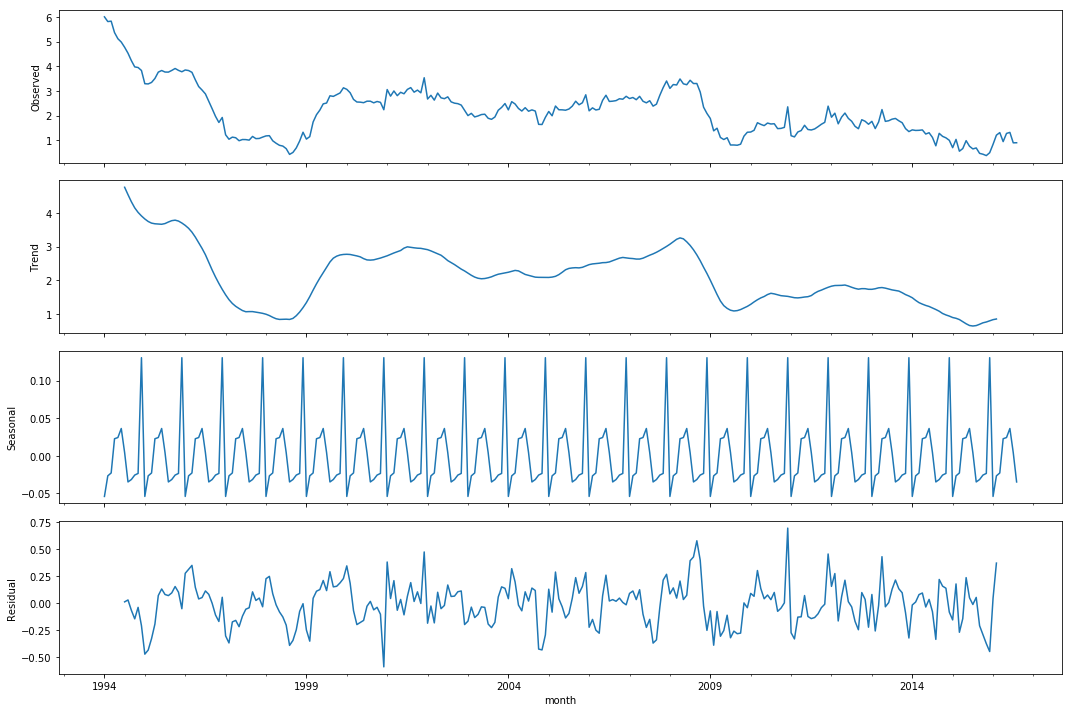

In [8]:
work['season_shift'] = work.anti_disp - work.anti_disp.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(work.season_shift[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work.season_shift[12:])[1])

Критерий Дики-Фуллера: p=0.000000


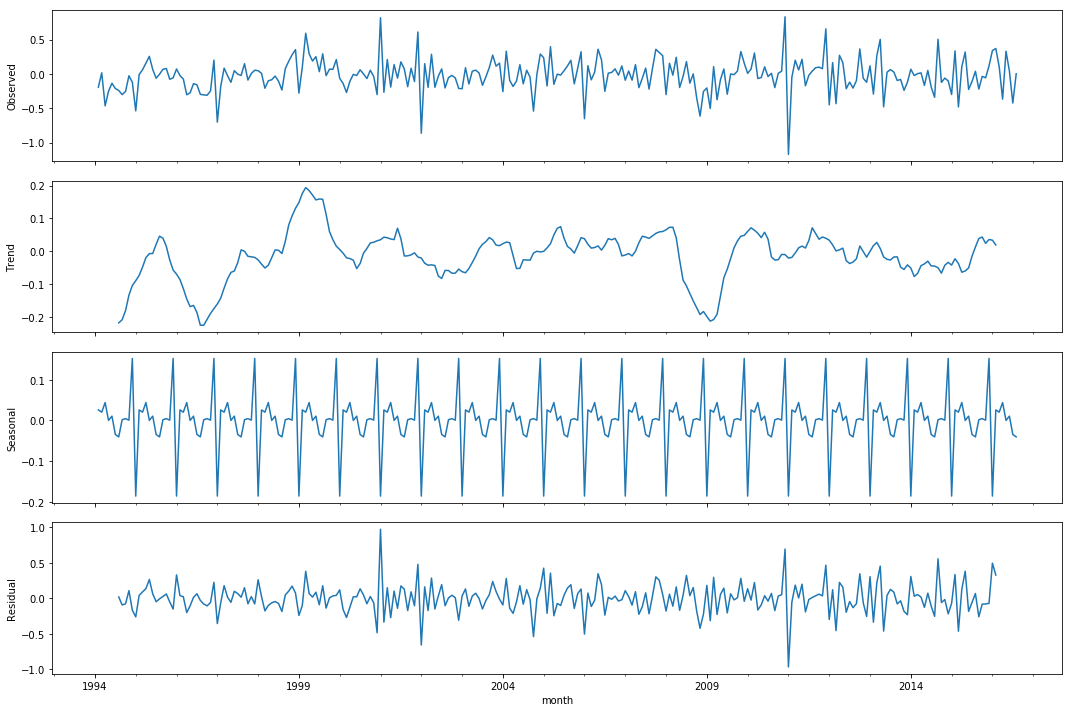

In [9]:
work['diff_shift'] = work.season_shift - work.season_shift.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(work.diff_shift[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work.diff_shift[13:])[1])

* Выбор начальных приближений для p, q, P, Q

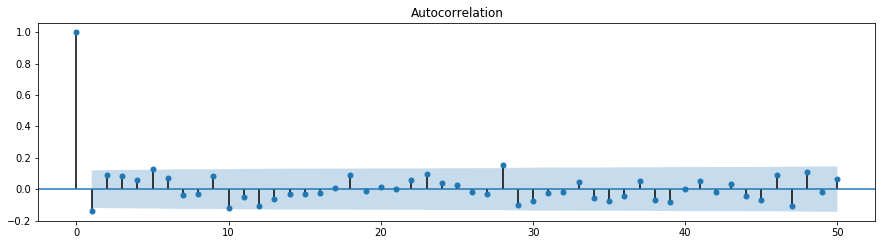

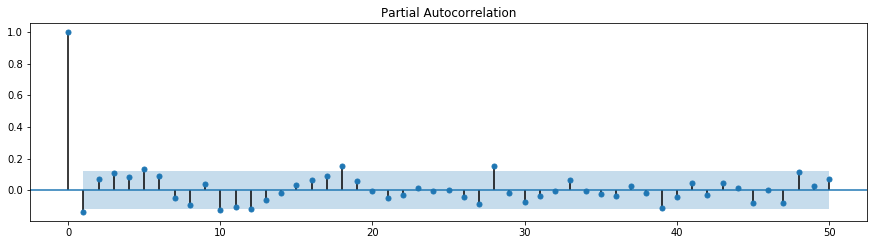

In [89]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(work.diff_shift[13:], lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(work.diff_shift[13:], lags=50, ax=ax)
pylab.show()

In [17]:
(Q, q) = (0, 28)
(P, p) = (1, 10)

* Обучение и сравнение моделей-кандидатов, выбор победителя

In [25]:
ps = range(0, p + 1)
d=1
qs = range(20, q + 2)
Ps = range(0, P + 1)
D=1
Qs = range(0, Q + 1)

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

220

In [27]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(work.anti_disp, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 20, 0, 0)
wrong parameters: (0, 20, 1, 0)
wrong parameters: (1, 20, 0, 0)
wrong parameters: (1, 20, 1, 0)


LinAlgError: Singular matrix

In [29]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
14  (0, 28, 0, 0) -16.322553
16  (0, 29, 0, 0) -15.206178
32  (1, 28, 0, 0) -14.812993
15  (0, 28, 1, 0) -14.274592
17  (0, 29, 1, 0) -13.236173


In [30]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                           anti_disp   No. Observations:                  284
Model:             SARIMAX(0, 1, 28)x(0, 1, 0, 12)   Log Likelihood                  37.161
Date:                             Sat, 15 Dec 2018   AIC                            -16.323
Time:                                     18:43:10   BIC                             89.498
Sample:                                 01-01-1993   HQIC                            26.103
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3011      0.459     -0.656      0.512      -1.200       0.598
ma.L2          0.1461      

* Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно * скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q

Критерий Стьюдента: p=0.293497
Критерий Дики-Фуллера: p=0.000000


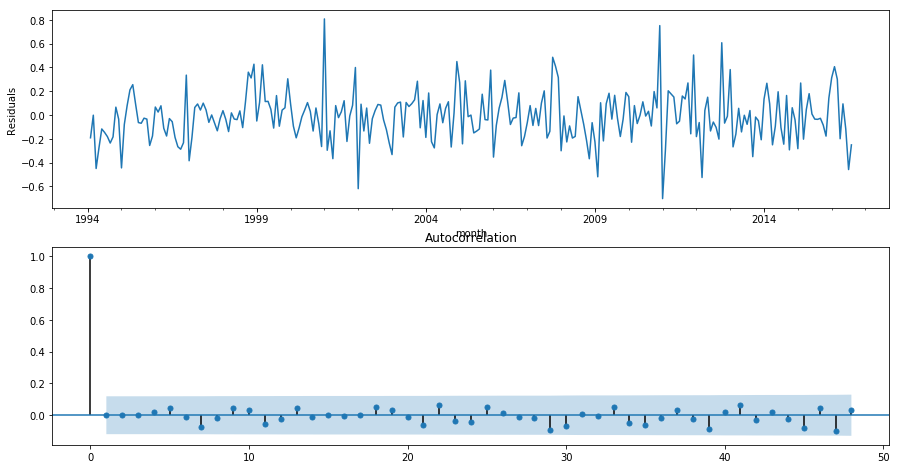

In [31]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

* Прогнозирование с помощью финальной модели.

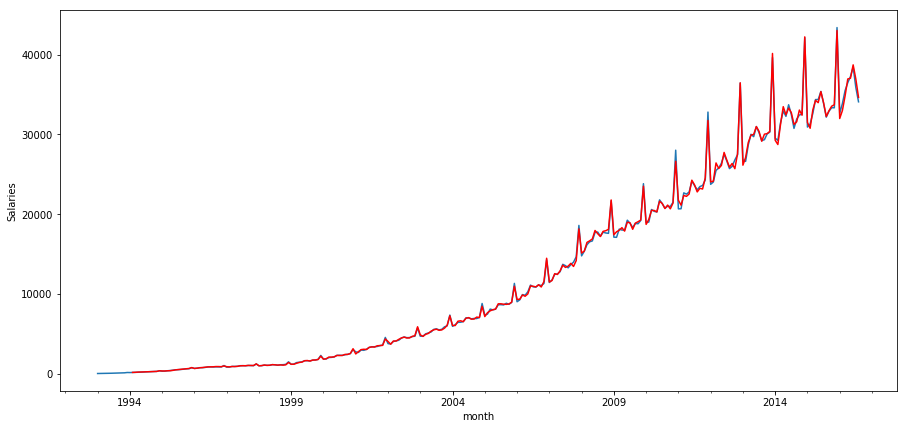

In [34]:
work['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
work.WAG_C_M.plot()
work.model[13:].plot(color='r')
plt.ylabel('Salaries')
pylab.show()

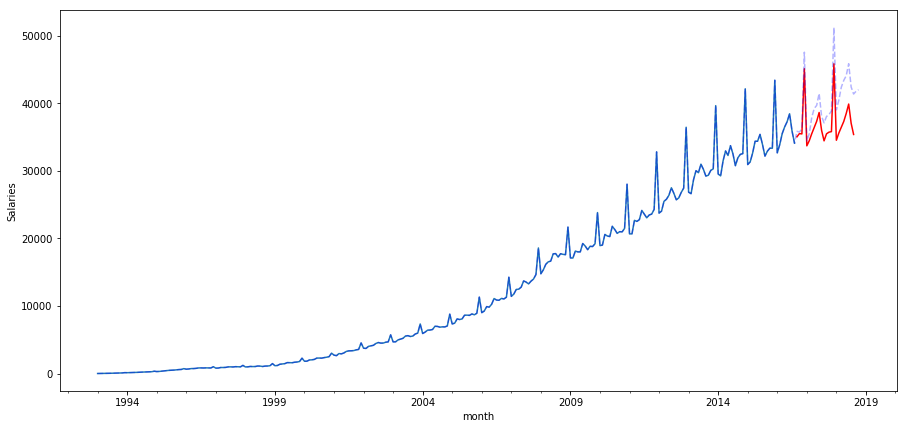

In [86]:
work2 = work[["WAG_C_M"]]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= work2.columns)
work2 = pd.concat([work2, future])
work2['forecast'] = invboxcox(best_model.predict(start=284, end=310), lmbda)

plt.figure(figsize(15,7))
work2.WAG_C_M.plot()
work2.forecast.plot(color='r')
plt.ylabel('Salaries')

work3 = pd.read_csv('UPD_WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
work3.WAG_C_M.plot(color='b', linestyle="dashed", alpha=0.3)
pylab.show()